# Introduction

trackintel documentation: https://trackintel.readthedocs.io/en/latest/modules/model.html#trackintel.Positionfixes

trackintel tutorial: https://github.com/mie-lab/trackintel/blob/master/examples/trackintel_basic_tutorial.ipynb

In [4]:
!pip install trackintel

In [5]:
import geopandas as gpd
import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import timedelta
from matplotlib import pyplot as plt
from multiprocessing import Pool
from shapely.geometry import LineString
from shapely.geometry import Point

import trackintel as ti

In [6]:
cityC = pd.read_csv('cityC_challengedata.csv.gz', compression='gzip')
cityC.head()

,uid,d,t,x,y
0,0,5,15,28,157
1,0,5,16,28,158
2,0,5,17,28,157
3,0,5,18,29,158
4,0,5,19,27,157


In [7]:
cityC.shape

(18456528, 5)

In [8]:
cityC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18456528 entries, 0 to 18456527
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 704.1 MB


`d`: Days since start of the data collection, ranges from 0-74 (the data is collected over 75 days)   
`t`: Ranges from 0-47 (the data is collected every 30 mins, there is 48 such periods in 1 day)

# Data Preprocessing

Limit the data to only the first month's data (30 days), i.e. `d` < 30.

In [12]:
cityC = cityC[cityC['d'] < 30]

In [13]:
cityC.shape

(7428781, 5)

In [14]:
# Save to a temporary file for later use
cityC.to_csv('cityC_filtered.csv', index=False)

Here, we define an arbitrary start date of the data collected.

In [16]:
# Define the start date
start_date = pd.to_datetime("2024-01-01")

In [17]:
def preprocess_data(data, start_date):
    # Create Point geometries
    geometry = [Point(xy) for xy in zip(data['x'], data['y'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)
    gdf.set_crs(epsg=3857, inplace=True)

    # Convert 'd' (days since start) to actual date
    gdf['date'] = start_date + pd.to_timedelta(gdf['d'], unit='D')
    
    # Convert 't' (30-minute intervals) to time of day
    gdf['time'] = pd.to_timedelta(gdf['t'] * 30, unit='m')  # Each 't' is multiplied by 30 minutes
    
    # Combine 'date' and 'time' into a single datetime column
    gdf['datetime'] = gdf['date'] + gdf['time']

    return gdf

In [18]:
def remove_consecutive_duplicates(sequence):
    """Remove consecutive duplicate coordinates from a sequence."""
    cleaned_sequence = [sequence[0]]  # Start with the first element
    for i in range(1, len(sequence)):
        if sequence[i] != sequence[i - 1]:  # Only add if different from the previous point
            cleaned_sequence.append(sequence[i])
    return cleaned_sequence

def preprocess_tripleg(dataset):
    """Preprocess each tripleg in the dataset by removing consecutive duplicates."""
    return [remove_consecutive_duplicates(sequence) for sequence in dataset]

In [19]:
def split_triplegs(triplegs, max_length):
    processed_triplegs = []
    for tripleg in triplegs:      
        # Split if the cleaned tripleg is too long
        if len(tripleg) > max_length:
            for i in range(0, len(tripleg), max_length):
                processed_triplegs.append(tripleg[i:i + max_length])
        else:
            processed_triplegs.append(tripleg)
    return processed_triplegs

# GSP Algorithm

In [21]:
class GSP:
    def __init__(self, sequences, min_support):
        self.sequences = sequences          # List of sequences with coordinate pairs
        self.min_support = min_support      # Minimum support threshold
        self.frequent_patterns = []         # Store all found frequent patterns

    def is_subsequence(self, candidate, sequence):
        candidate_index = 0  # Start with the first element of candidate
        for item in sequence:
            if item == candidate[candidate_index]:  # Check if current item matches the current candidate element
                candidate_index += 1  # Move to the next element in candidate
                if candidate_index == len(candidate):  # If we matched all elements in candidate, it's a subsequence
                    return True
        return False  # If we finish the loop without matching all of candidate, return False
    
    def count_support(self, candidates):
        """
        Count the support of each candidate in the sequences
        """
        support_count = defaultdict(int)
        for sequence in self.sequences:
            # Filter out sequences that are too short to contain any candidates of the current length
            if len(sequence) < len(next(iter(candidates))):  # All candidates are of the same length
                continue
                
            for candidate in candidates:
                if support_count[candidate] >= min_support: # Early stopping: stop counting if min_support is reached
                    continue
                    
                if self.is_subsequence(candidate, sequence):
                    support_count[candidate] += 1

        # Filter out candidates that meet minimum support threshold
        support_count = {seq: count for seq, count in support_count.items() if count >= self.min_support}
        return support_count

    def generate_candidates(self, prev_frequent_patterns, k):
        """Generate candidate sequences of a specified length by merging sequences with common prefixes/suffixes.
        Includes Apriori check to remove candidate sequences with any non-frequent subsequence.
        """
        candidates = set()
        for pattern1 in prev_frequent_patterns:
            for pattern2 in prev_frequent_patterns:
                if pattern1 == pattern2: # Don't merge the same sequences
                    continue
                # Merge two sequences if they share k-1 items
                if pattern1[1:] == pattern2[:-1]:  # Ensure that only relevant sequences are merged
                    candidate = pattern1 + (pattern2[-1],)
                    # Apriori check: Keep only if all (k-1) subsequences are frequent
                    if all(candidate[i:i+k-1] in prev_frequent_patterns for i in range(len(candidate) - k + 1)):
                        candidates.add(candidate)
                        
        return candidates

    def run(self):
        """
        Run the GSP algorithm
        """
        # Step 1: Find frequent 1-sequences (individual locations)
        all_items = set(item for sequence in self.sequences for item in sequence)
        initial_candidates = [(item,) for item in all_items]
        frequent_patterns = self.count_support(initial_candidates)
        
        # Add to result list
        self.frequent_patterns.extend(frequent_patterns.items())
        print("1-itemsets done!")
        
        k = 2  # Start with 2-sequences

        while frequent_patterns:
            # Step 2: Generate candidate k-sequences (those with infrequent subsequences are removed)
            candidates = self.generate_candidates(frequent_patterns.keys(), k)
            if not candidates: # Break if no new candidates are generated
                print(f"No new candidates generated. Stopping at {k-1}-itemsets")
                break
            
            # Step 3: Count support for each candidate (those that do not meet min_support are removed)
            frequent_patterns = self.count_support(candidates)
            
            # Add found frequent patterns to result list
            if frequent_patterns:
                self.frequent_patterns.extend(frequent_patterns.items())
                print(f"{k}-itemsets done!")
            
            # Move to the next level
            k += 1

        return self.frequent_patterns

In [22]:
# Define constants
chunk_size = 100000  # Number of rows to load per chunk
min_support = 10  # Minimum support for frequent patterns
gap_threshold_sp = 45  # Gap threshold for staypoint detection
gap_threshold_trip = 45 # Gap threshold for triplegs generation
dist_threshold = 10  # Distance threshold for staypoints
max_tripleg_length = 10 # Maximum length of each tripleg

In [23]:
# Dictionary to store patterns by chunk
all_frequent_patterns = defaultdict(list)

In [24]:
# Process data in chunks
for chunk in pd.read_csv('cityC_filtered.csv', chunksize=chunk_size):
    # Preprocess each chunk
    gdf_chunk = preprocess_data(chunk, start_date)
    
    # Generate position fixes and triplegs
    pfs_chunk = ti.io.read_positionfixes_gpd(gdf_chunk, tracked_at="datetime", user_id="uid", geom_col="geometry", tz='Asia/Tokyo')
    pfs_chunk, sp_chunk = pfs_chunk.as_positionfixes.generate_staypoints(gap_threshold=gap_threshold_sp, dist_threshold=dist_threshold, 
                                                                         print_progress=True)
    pfs_chunk, tpls_chunk = pfs_chunk.generate_triplegs(staypoints=sp_chunk, method='overlap_staypoints', gap_threshold=gap_threshold_trip)

    print(gdf_chunk[:5])
    
    # Convert triplegs to sequences
    tpls_chunk['tripleg_list'] = tpls_chunk['geom'].apply(lambda geom: list(geom.coords))
    tripleg_list = tpls_chunk['tripleg_list'].tolist()
    
    # Preprocess triplegs by removing consecutive duplicates
    processed_triplegs = preprocess_tripleg(tripleg_list)
    splitted_triplegs = split_triplegs(processed_triplegs, 10)
    
    # Apply GSP on each chunk and collect patterns
    gsp = GSP(splitted_triplegs, min_support)
    frequent_patterns_chunk = gsp.run()
    all_frequent_patterns.update(frequent_patterns_chunk)

100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:18<00:00, 12.05it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

   uid  d   t   x    y                geometry       date            time  \
0    0  5  15  28  157  POINT (28.000 157.000) 2024-01-06 0 days 07:30:00   
1    0  5  16  28  158  POINT (28.000 158.000) 2024-01-06 0 days 08:00:00   
2    0  5  17  28  157  POINT (28.000 157.000) 2024-01-06 0 days 08:30:00   
3    0  5  18  29  158  POINT (29.000 158.000) 2024-01-06 0 days 09:00:00   
4    0  5  19  27  157  POINT (27.000 157.000) 2024-01-06 0 days 09:30:00   

             datetime  
0 2024-01-06 07:30:00  
1 2024-01-06 08:00:00  
2 2024-01-06 08:30:00  
3 2024-01-06 09:00:00  
4 2024-01-06 09:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.18it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid   d   t   x    y                geometry       date  \
100000  226  22  29  43  167  POINT (43.000 167.000) 2024-01-23   
100001  226  22  30  21  170  POINT (21.000 170.000) 2024-01-23   
100002  226  22  31  13  171  POINT (13.000 171.000) 2024-01-23   
100003  226  22  32  13  171  POINT (13.000 171.000) 2024-01-23   
100004  226  22  35  13  160  POINT (13.000 160.000) 2024-01-23   

                  time            datetime  
100000 0 days 14:30:00 2024-01-23 14:30:00  
100001 0 days 15:00:00 2024-01-23 15:00:00  
100002 0 days 15:30:00 2024-01-23 15:30:00  
100003 0 days 16:00:00 2024-01-23 16:00:00  
100004 0 days 17:30:00 2024-01-23 17:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:18<00:00, 13.04it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid   d   t   x    y                geometry       date  \
200000  464  23  19  24  157  POINT (24.000 157.000) 2024-01-24   
200001  464  23  25  24  157  POINT (24.000 157.000) 2024-01-24   
200002  464  23  32  24  158  POINT (24.000 158.000) 2024-01-24   
200003  464  23  35  24  157  POINT (24.000 157.000) 2024-01-24   
200004  464  23  39  24  157  POINT (24.000 157.000) 2024-01-24   

                  time            datetime  
200000 0 days 09:30:00 2024-01-24 09:30:00  
200001 0 days 12:30:00 2024-01-24 12:30:00  
200002 0 days 16:00:00 2024-01-24 16:00:00  
200003 0 days 17:30:00 2024-01-24 17:30:00  
200004 0 days 19:30:00 2024-01-24 19:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:17<00:00, 14.35it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid  d   t   x    y                geometry       date  \
300000  708  2  16  29  152  POINT (29.000 152.000) 2024-01-03   
300001  708  2  17  28  152  POINT (28.000 152.000) 2024-01-03   
300002  708  2  18  26  149  POINT (26.000 149.000) 2024-01-03   
300003  708  2  20  26  150  POINT (26.000 150.000) 2024-01-03   
300004  708  2  21  26  150  POINT (26.000 150.000) 2024-01-03   

                  time            datetime  
300000 0 days 08:00:00 2024-01-03 08:00:00  
300001 0 days 08:30:00 2024-01-03 08:30:00  
300002 0 days 09:00:00 2024-01-03 09:00:00  
300003 0 days 10:00:00 2024-01-03 10:00:00  
300004 0 days 10:30:00 2024-01-03 10:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [00:18<00:00, 14.47it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid   d   t   x    y                geometry       date  \
400000  957  11  37  20  160  POINT (20.000 160.000) 2024-01-12   
400001  957  11  38  19  162  POINT (19.000 162.000) 2024-01-12   
400002  957  12  15  25  153  POINT (25.000 153.000) 2024-01-13   
400003  957  12  16  25  153  POINT (25.000 153.000) 2024-01-13   
400004  957  12  18  25  152  POINT (25.000 152.000) 2024-01-13   

                  time            datetime  
400000 0 days 18:30:00 2024-01-12 18:30:00  
400001 0 days 19:00:00 2024-01-12 19:00:00  
400002 0 days 07:30:00 2024-01-13 07:30:00  
400003 0 days 08:00:00 2024-01-13 08:00:00  
400004 0 days 09:00:00 2024-01-13 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [00:16<00:00, 15.55it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d   t   x    y                geometry       date  \
500000  1223  24  28  23  159  POINT (23.000 159.000) 2024-01-25   
500001  1223  24  29  25  160  POINT (25.000 160.000) 2024-01-25   
500002  1223  24  32  26  156  POINT (26.000 156.000) 2024-01-25   
500003  1223  24  33  31  155  POINT (31.000 155.000) 2024-01-25   
500004  1223  24  34  33  154  POINT (33.000 154.000) 2024-01-25   

                  time            datetime  
500000 0 days 14:00:00 2024-01-25 14:00:00  
500001 0 days 14:30:00 2024-01-25 14:30:00  
500002 0 days 16:00:00 2024-01-25 16:00:00  
500003 0 days 16:30:00 2024-01-25 16:30:00  
500004 0 days 17:00:00 2024-01-25 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [00:16<00:00, 15.38it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d   t   x    y                geometry       date  \
600000  1484  17  33  32  149  POINT (32.000 149.000) 2024-01-18   
600001  1484  17  34  32  151  POINT (32.000 151.000) 2024-01-18   
600002  1484  17  35  35  144  POINT (35.000 144.000) 2024-01-18   
600003  1484  17  36  36  140  POINT (36.000 140.000) 2024-01-18   
600004  1484  18  18  32  156  POINT (32.000 156.000) 2024-01-19   

                  time            datetime  
600000 0 days 16:30:00 2024-01-18 16:30:00  
600001 0 days 17:00:00 2024-01-18 17:00:00  
600002 0 days 17:30:00 2024-01-18 17:30:00  
600003 0 days 18:00:00 2024-01-18 18:00:00  
600004 0 days 09:00:00 2024-01-19 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:17<00:00, 14.23it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d  t   x    y                geometry       date  \
700000  1744  10  4  26  154  POINT (26.000 154.000) 2024-01-11   
700001  1744  10  5  24  154  POINT (24.000 154.000) 2024-01-11   
700002  1744  10  6  13  169  POINT (13.000 169.000) 2024-01-11   
700003  1744  10  7  14  169  POINT (14.000 169.000) 2024-01-11   
700004  1744  10  8  19  167  POINT (19.000 167.000) 2024-01-11   

                  time            datetime  
700000 0 days 02:00:00 2024-01-11 02:00:00  
700001 0 days 02:30:00 2024-01-11 02:30:00  
700002 0 days 03:00:00 2024-01-11 03:00:00  
700003 0 days 03:30:00 2024-01-11 03:30:00  
700004 0 days 04:00:00 2024-01-11 04:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:20<00:00, 12.96it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d   t   x    y                geometry       date  \
800000  1991  14  29  33  133  POINT (33.000 133.000) 2024-01-15   
800001  1991  14  30  34  133  POINT (34.000 133.000) 2024-01-15   
800002  1991  14  32  33  133  POINT (33.000 133.000) 2024-01-15   
800003  1991  14  33  33  133  POINT (33.000 133.000) 2024-01-15   
800004  1991  14  34  33  133  POINT (33.000 133.000) 2024-01-15   

                  time            datetime  
800000 0 days 14:30:00 2024-01-15 14:30:00  
800001 0 days 15:00:00 2024-01-15 15:00:00  
800002 0 days 16:00:00 2024-01-15 16:00:00  
800003 0 days 16:30:00 2024-01-15 16:30:00  
800004 0 days 17:00:00 2024-01-15 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.32it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d   t   x    y                geometry       date  \
900000  2253  25  31  22  178  POINT (22.000 178.000) 2024-01-26   
900001  2253  25  39  21  178  POINT (21.000 178.000) 2024-01-26   
900002  2253  26  14  21  170  POINT (21.000 170.000) 2024-01-27   
900003  2253  26  15  29  166  POINT (29.000 166.000) 2024-01-27   
900004  2253  26  16  50  148  POINT (50.000 148.000) 2024-01-27   

                  time            datetime  
900000 0 days 15:30:00 2024-01-26 15:30:00  
900001 0 days 19:30:00 2024-01-26 19:30:00  
900002 0 days 07:00:00 2024-01-27 07:00:00  
900003 0 days 07:30:00 2024-01-27 07:30:00  
900004 0 days 08:00:00 2024-01-27 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:18<00:00, 13.30it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1000000  2499  24  40  27  182  POINT (27.000 182.000) 2024-01-25   
1000001  2499  24  41  29  158  POINT (29.000 158.000) 2024-01-25   
1000002  2499  25  14  24  179  POINT (24.000 179.000) 2024-01-26   
1000003  2499  25  15  26  182  POINT (26.000 182.000) 2024-01-26   
1000004  2499  25  16  27  183  POINT (27.000 183.000) 2024-01-26   

                   time            datetime  
1000000 0 days 20:00:00 2024-01-25 20:00:00  
1000001 0 days 20:30:00 2024-01-25 20:30:00  
1000002 0 days 07:00:00 2024-01-26 07:00:00  
1000003 0 days 07:30:00 2024-01-26 07:30:00  
1000004 0 days 08:00:00 2024-01-26 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:18<00:00, 12.44it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1100000  2751  11  16  14  153  POINT (14.000 153.000) 2024-01-12   
1100001  2751  11  17  13  153  POINT (13.000 153.000) 2024-01-12   
1100002  2751  11  19  14  153  POINT (14.000 153.000) 2024-01-12   
1100003  2751  11  20  14  153  POINT (14.000 153.000) 2024-01-12   
1100004  2751  11  22  14  153  POINT (14.000 153.000) 2024-01-12   

                   time            datetime  
1100000 0 days 08:00:00 2024-01-12 08:00:00  
1100001 0 days 08:30:00 2024-01-12 08:30:00  
1100002 0 days 09:30:00 2024-01-12 09:30:00  
1100003 0 days 10:00:00 2024-01-12 10:00:00  
1100004 0 days 11:00:00 2024-01-12 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:14<00:00, 17.51it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d  t   x    y                geometry       date  \
1200000  2981  28  2  32  140  POINT (32.000 140.000) 2024-01-29   
1200001  2981  28  4  33  142  POINT (33.000 142.000) 2024-01-29   
1200002  2981  28  6  33  142  POINT (33.000 142.000) 2024-01-29   
1200003  2981  28  7  32  140  POINT (32.000 140.000) 2024-01-29   
1200004  2981  28  9  33  142  POINT (33.000 142.000) 2024-01-29   

                   time            datetime  
1200000 0 days 01:00:00 2024-01-29 01:00:00  
1200001 0 days 02:00:00 2024-01-29 02:00:00  
1200002 0 days 03:00:00 2024-01-29 03:00:00  
1200003 0 days 03:30:00 2024-01-29 03:30:00  
1200004 0 days 04:30:00 2024-01-29 04:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:18<00:00, 13.66it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1300000  3230  22  21  24  150  POINT (24.000 150.000) 2024-01-23   
1300001  3230  22  22  24  150  POINT (24.000 150.000) 2024-01-23   
1300002  3230  22  23  25  150  POINT (25.000 150.000) 2024-01-23   
1300003  3230  22  24  24  151  POINT (24.000 151.000) 2024-01-23   
1300004  3230  22  25  25  151  POINT (25.000 151.000) 2024-01-23   

                   time            datetime  
1300000 0 days 10:30:00 2024-01-23 10:30:00  
1300001 0 days 11:00:00 2024-01-23 11:00:00  
1300002 0 days 11:30:00 2024-01-23 11:30:00  
1300003 0 days 12:00:00 2024-01-23 12:00:00  
1300004 0 days 12:30:00 2024-01-23 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:17<00:00, 14.21it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1400000  3478  24  19  32  156  POINT (32.000 156.000) 2024-01-25   
1400001  3478  24  20  27  159  POINT (27.000 159.000) 2024-01-25   
1400002  3478  24  21  33  163  POINT (33.000 163.000) 2024-01-25   
1400003  3478  24  23  33  161  POINT (33.000 161.000) 2024-01-25   
1400004  3478  24  27  33  163  POINT (33.000 163.000) 2024-01-25   

                   time            datetime  
1400000 0 days 09:30:00 2024-01-25 09:30:00  
1400001 0 days 10:00:00 2024-01-25 10:00:00  
1400002 0 days 10:30:00 2024-01-25 10:30:00  
1400003 0 days 11:30:00 2024-01-25 11:30:00  
1400004 0 days 13:30:00 2024-01-25 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 14.46it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x   y               geometry       date  \
1500000  3730  10  24  48  88  POINT (48.000 88.000) 2024-01-11   
1500001  3730  10  26  48  88  POINT (48.000 88.000) 2024-01-11   
1500002  3730  10  31  49  88  POINT (49.000 88.000) 2024-01-11   
1500003  3730  10  32  49  87  POINT (49.000 87.000) 2024-01-11   
1500004  3730  10  33  49  87  POINT (49.000 87.000) 2024-01-11   

                   time            datetime  
1500000 0 days 12:00:00 2024-01-11 12:00:00  
1500001 0 days 13:00:00 2024-01-11 13:00:00  
1500002 0 days 15:30:00 2024-01-11 15:30:00  
1500003 0 days 16:00:00 2024-01-11 16:00:00  
1500004 0 days 16:30:00 2024-01-11 16:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [00:13<00:00, 18.86it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1600000  3976  29  36  41  146  POINT (41.000 146.000) 2024-01-30   
1600001  3977   0  21  34  146  POINT (34.000 146.000) 2024-01-01   
1600002  3977   0  23  36  140  POINT (36.000 140.000) 2024-01-01   
1600003  3977   0  24  37  156  POINT (37.000 156.000) 2024-01-01   
1600004  3977   0  27  26  152  POINT (26.000 152.000) 2024-01-01   

                   time            datetime  
1600000 0 days 18:00:00 2024-01-30 18:00:00  
1600001 0 days 10:30:00 2024-01-01 10:30:00  
1600002 0 days 11:30:00 2024-01-01 11:30:00  
1600003 0 days 12:00:00 2024-01-01 12:00:00  
1600004 0 days 13:30:00 2024-01-01 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:15<00:00, 16.65it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1700000  4236  10  25  27  171  POINT (27.000 171.000) 2024-01-11   
1700001  4236  10  26  27  170  POINT (27.000 170.000) 2024-01-11   
1700002  4236  10  27  27  170  POINT (27.000 170.000) 2024-01-11   
1700003  4236  10  28  27  170  POINT (27.000 170.000) 2024-01-11   
1700004  4236  10  29  28  171  POINT (28.000 171.000) 2024-01-11   

                   time            datetime  
1700000 0 days 12:30:00 2024-01-11 12:30:00  
1700001 0 days 13:00:00 2024-01-11 13:00:00  
1700002 0 days 13:30:00 2024-01-11 13:30:00  
1700003 0 days 14:00:00 2024-01-11 14:00:00  
1700004 0 days 14:30:00 2024-01-11 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:19<00:00, 13.31it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1800000  4492  23   5  54   68   POINT (54.000 68.000) 2024-01-24   
1800001  4492  23  14  55   69   POINT (55.000 69.000) 2024-01-24   
1800002  4492  23  16  41  113  POINT (41.000 113.000) 2024-01-24   
1800003  4492  23  18  28  151  POINT (28.000 151.000) 2024-01-24   
1800004  4492  23  23  29  149  POINT (29.000 149.000) 2024-01-24   

                   time            datetime  
1800000 0 days 02:30:00 2024-01-24 02:30:00  
1800001 0 days 07:00:00 2024-01-24 07:00:00  
1800002 0 days 08:00:00 2024-01-24 08:00:00  
1800003 0 days 09:00:00 2024-01-24 09:00:00  
1800004 0 days 11:30:00 2024-01-24 11:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [00:17<00:00, 14.90it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1900000  4753  18  29  17  174  POINT (17.000 174.000) 2024-01-19   
1900001  4753  18  30  17  174  POINT (17.000 174.000) 2024-01-19   
1900002  4753  18  31  19  170  POINT (19.000 170.000) 2024-01-19   
1900003  4753  18  32  18  173  POINT (18.000 173.000) 2024-01-19   
1900004  4753  18  33  18  173  POINT (18.000 173.000) 2024-01-19   

                   time            datetime  
1900000 0 days 14:30:00 2024-01-19 14:30:00  
1900001 0 days 15:00:00 2024-01-19 15:00:00  
1900002 0 days 15:30:00 2024-01-19 15:30:00  
1900003 0 days 16:00:00 2024-01-19 16:00:00  
1900004 0 days 16:30:00 2024-01-19 16:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [00:17<00:00, 15.35it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
2000000  5019  21  14  35  154  POINT (35.000 154.000) 2024-01-22   
2000001  5019  21  15  20  172  POINT (20.000 172.000) 2024-01-22   
2000002  5019  21  16  38  154  POINT (38.000 154.000) 2024-01-22   
2000003  5019  21  23  38  155  POINT (38.000 155.000) 2024-01-22   
2000004  5019  21  24  34  138  POINT (34.000 138.000) 2024-01-22   

                   time            datetime  
2000000 0 days 07:00:00 2024-01-22 07:00:00  
2000001 0 days 07:30:00 2024-01-22 07:30:00  
2000002 0 days 08:00:00 2024-01-22 08:00:00  
2000003 0 days 11:30:00 2024-01-22 11:30:00  
2000004 0 days 12:00:00 2024-01-22 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 13.79it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x    y                geometry       date  \
2100000  5294  6  24  32  155  POINT (32.000 155.000) 2024-01-07   
2100001  5294  6  28  32  155  POINT (32.000 155.000) 2024-01-07   
2100002  5294  6  29  33  145  POINT (33.000 145.000) 2024-01-07   
2100003  5294  6  30  39  125  POINT (39.000 125.000) 2024-01-07   
2100004  5294  6  36  41  131  POINT (41.000 131.000) 2024-01-07   

                   time            datetime  
2100000 0 days 12:00:00 2024-01-07 12:00:00  
2100001 0 days 14:00:00 2024-01-07 14:00:00  
2100002 0 days 14:30:00 2024-01-07 14:30:00  
2100003 0 days 15:00:00 2024-01-07 15:00:00  
2100004 0 days 18:00:00 2024-01-07 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:22<00:00, 10.93it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x    y                geometry       date  \
2200000  5546  3  41  14  172  POINT (14.000 172.000) 2024-01-04   
2200001  5546  4  11  23  174  POINT (23.000 174.000) 2024-01-05   
2200002  5546  4  12  15  175  POINT (15.000 175.000) 2024-01-05   
2200003  5546  4  26  21  170  POINT (21.000 170.000) 2024-01-05   
2200004  5546  4  27  32  143  POINT (32.000 143.000) 2024-01-05   

                   time            datetime  
2200000 0 days 20:30:00 2024-01-04 20:30:00  
2200001 0 days 05:30:00 2024-01-05 05:30:00  
2200002 0 days 06:00:00 2024-01-05 06:00:00  
2200003 0 days 13:00:00 2024-01-05 13:00:00  
2200004 0 days 13:30:00 2024-01-05 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:19<00:00, 13.32it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
2300000  5789  19  42  23  169  POINT (23.000 169.000) 2024-01-20   
2300001  5789  19  43  23  169  POINT (23.000 169.000) 2024-01-20   
2300002  5789  19  44  24  169  POINT (24.000 169.000) 2024-01-20   
2300003  5789  19  45  23  169  POINT (23.000 169.000) 2024-01-20   
2300004  5789  19  46  23  169  POINT (23.000 169.000) 2024-01-20   

                   time            datetime  
2300000 0 days 21:00:00 2024-01-20 21:00:00  
2300001 0 days 21:30:00 2024-01-20 21:30:00  
2300002 0 days 22:00:00 2024-01-20 22:00:00  
2300003 0 days 22:30:00 2024-01-20 22:30:00  
2300004 0 days 23:00:00 2024-01-20 23:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:18<00:00, 13.64it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
2400000  6047  12  26  25  135  POINT (25.000 135.000) 2024-01-13   
2400001  6047  12  27  25  135  POINT (25.000 135.000) 2024-01-13   
2400002  6047  12  28  25  134  POINT (25.000 134.000) 2024-01-13   
2400003  6047  12  29  25  135  POINT (25.000 135.000) 2024-01-13   
2400004  6047  12  30  25  135  POINT (25.000 135.000) 2024-01-13   

                   time            datetime  
2400000 0 days 13:00:00 2024-01-13 13:00:00  
2400001 0 days 13:30:00 2024-01-13 13:30:00  
2400002 0 days 14:00:00 2024-01-13 14:00:00  
2400003 0 days 14:30:00 2024-01-13 14:30:00  
2400004 0 days 15:00:00 2024-01-13 15:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 13.68it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x    y                geometry       date  \
2500000  6302  0  44  38  145  POINT (38.000 145.000) 2024-01-01   
2500001  6302  0  45  38  145  POINT (38.000 145.000) 2024-01-01   
2500002  6302  1  15  38  145  POINT (38.000 145.000) 2024-01-02   
2500003  6302  1  16  38  145  POINT (38.000 145.000) 2024-01-02   
2500004  6302  1  18  38  145  POINT (38.000 145.000) 2024-01-02   

                   time            datetime  
2500000 0 days 22:00:00 2024-01-01 22:00:00  
2500001 0 days 22:30:00 2024-01-01 22:30:00  
2500002 0 days 07:30:00 2024-01-02 07:30:00  
2500003 0 days 08:00:00 2024-01-02 08:00:00  
2500004 0 days 09:00:00 2024-01-02 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 268/268 [00:18<00:00, 14.86it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
2600000  6556  21  36  40  126  POINT (40.000 126.000) 2024-01-22   
2600001  6556  21  37  41  116  POINT (41.000 116.000) 2024-01-22   
2600002  6556  22  12  41  113  POINT (41.000 113.000) 2024-01-23   
2600003  6556  22  13  48   92   POINT (48.000 92.000) 2024-01-23   
2600004  6556  22  23  60   85   POINT (60.000 85.000) 2024-01-23   

                   time            datetime  
2600000 0 days 18:00:00 2024-01-22 18:00:00  
2600001 0 days 18:30:00 2024-01-22 18:30:00  
2600002 0 days 06:00:00 2024-01-23 06:00:00  
2600003 0 days 06:30:00 2024-01-23 06:30:00  
2600004 0 days 11:30:00 2024-01-23 11:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:17<00:00, 15.59it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
2700000  6825  12  38  33  158  POINT (33.000 158.000) 2024-01-13   
2700001  6825  12  39  30  160  POINT (30.000 160.000) 2024-01-13   
2700002  6825  12  40  31  160  POINT (31.000 160.000) 2024-01-13   
2700003  6825  12  42  30  160  POINT (30.000 160.000) 2024-01-13   
2700004  6825  12  43  31  160  POINT (31.000 160.000) 2024-01-13   

                   time            datetime  
2700000 0 days 19:00:00 2024-01-13 19:00:00  
2700001 0 days 19:30:00 2024-01-13 19:30:00  
2700002 0 days 20:00:00 2024-01-13 20:00:00  
2700003 0 days 21:00:00 2024-01-13 21:00:00  
2700004 0 days 21:30:00 2024-01-13 21:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 262/262 [00:14<00:00, 17.87it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d  t   x    y                geometry       date  \
2800000  7094  24  1  33  142  POINT (33.000 142.000) 2024-01-25   
2800001  7094  24  2  33  143  POINT (33.000 143.000) 2024-01-25   
2800002  7094  24  3  33  142  POINT (33.000 142.000) 2024-01-25   
2800003  7094  24  4  33  142  POINT (33.000 142.000) 2024-01-25   
2800004  7094  24  5  33  142  POINT (33.000 142.000) 2024-01-25   

                   time            datetime  
2800000 0 days 00:30:00 2024-01-25 00:30:00  
2800001 0 days 01:00:00 2024-01-25 01:00:00  
2800002 0 days 01:30:00 2024-01-25 01:30:00  
2800003 0 days 02:00:00 2024-01-25 02:00:00  
2800004 0 days 02:30:00 2024-01-25 02:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:17<00:00, 15.12it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
2900000  7357  16  10  51   38   POINT (51.000 38.000) 2024-01-17   
2900001  7357  16  11  51   38   POINT (51.000 38.000) 2024-01-17   
2900002  7357  16  12  50   39   POINT (50.000 39.000) 2024-01-17   
2900003  7357  16  13  56   72   POINT (56.000 72.000) 2024-01-17   
2900004  7357  16  14  40  117  POINT (40.000 117.000) 2024-01-17   

                   time            datetime  
2900000 0 days 05:00:00 2024-01-17 05:00:00  
2900001 0 days 05:30:00 2024-01-17 05:30:00  
2900002 0 days 06:00:00 2024-01-17 06:00:00  
2900003 0 days 06:30:00 2024-01-17 06:30:00  
2900004 0 days 07:00:00 2024-01-17 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:18<00:00, 14.58it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3000000  7620  20  43  11  170  POINT (11.000 170.000) 2024-01-21   
3000001  7620  20  44  11  172  POINT (11.000 172.000) 2024-01-21   
3000002  7620  21   0  11  172  POINT (11.000 172.000) 2024-01-22   
3000003  7620  21   1  10  171  POINT (10.000 171.000) 2024-01-22   
3000004  7620  21   4  11  172  POINT (11.000 172.000) 2024-01-22   

                   time            datetime  
3000000 0 days 21:30:00 2024-01-21 21:30:00  
3000001 0 days 22:00:00 2024-01-21 22:00:00  
3000002 0 days 00:00:00 2024-01-22 00:00:00  
3000003 0 days 00:30:00 2024-01-22 00:30:00  
3000004 0 days 02:00:00 2024-01-22 02:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [00:21<00:00, 12.90it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x    y                geometry       date  \
3100000  7885  8  24  29  144  POINT (29.000 144.000) 2024-01-09   
3100001  7885  8  26  26  145  POINT (26.000 145.000) 2024-01-09   
3100002  7885  8  27  27  145  POINT (27.000 145.000) 2024-01-09   
3100003  7885  8  28  27  136  POINT (27.000 136.000) 2024-01-09   
3100004  7885  8  29  33  141  POINT (33.000 141.000) 2024-01-09   

                   time            datetime  
3100000 0 days 12:00:00 2024-01-09 12:00:00  
3100001 0 days 13:00:00 2024-01-09 13:00:00  
3100002 0 days 13:30:00 2024-01-09 13:30:00  
3100003 0 days 14:00:00 2024-01-09 14:00:00  
3100004 0 days 14:30:00 2024-01-09 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 262/262 [00:14<00:00, 17.61it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3200000  8156  13  20  32  188  POINT (32.000 188.000) 2024-01-14   
3200001  8156  13  21  35  192  POINT (35.000 192.000) 2024-01-14   
3200002  8156  13  27  28  183  POINT (28.000 183.000) 2024-01-14   
3200003  8156  13  35  30  182  POINT (30.000 182.000) 2024-01-14   
3200004  8156  13  36  27  182  POINT (27.000 182.000) 2024-01-14   

                   time            datetime  
3200000 0 days 10:00:00 2024-01-14 10:00:00  
3200001 0 days 10:30:00 2024-01-14 10:30:00  
3200002 0 days 13:30:00 2024-01-14 13:30:00  
3200003 0 days 17:30:00 2024-01-14 17:30:00  
3200004 0 days 18:00:00 2024-01-14 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 15.55it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x    y                geometry       date  \
3300000  8419  9  11  11  176  POINT (11.000 176.000) 2024-01-10   
3300001  8419  9  18  19  174  POINT (19.000 174.000) 2024-01-10   
3300002  8419  9  19  20  173  POINT (20.000 173.000) 2024-01-10   
3300003  8419  9  20  22  169  POINT (22.000 169.000) 2024-01-10   
3300004  8419  9  21  33  141  POINT (33.000 141.000) 2024-01-10   

                   time            datetime  
3300000 0 days 05:30:00 2024-01-10 05:30:00  
3300001 0 days 09:00:00 2024-01-10 09:00:00  
3300002 0 days 09:30:00 2024-01-10 09:30:00  
3300003 0 days 10:00:00 2024-01-10 10:00:00  
3300004 0 days 10:30:00 2024-01-10 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:15<00:00, 17.14it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3400000  8669  28  25  32  163  POINT (32.000 163.000) 2024-01-29   
3400001  8669  28  26  32  163  POINT (32.000 163.000) 2024-01-29   
3400002  8669  28  27  28  162  POINT (28.000 162.000) 2024-01-29   
3400003  8669  29  23  30  164  POINT (30.000 164.000) 2024-01-30   
3400004  8669  29  24  32  162  POINT (32.000 162.000) 2024-01-30   

                   time            datetime  
3400000 0 days 12:30:00 2024-01-29 12:30:00  
3400001 0 days 13:00:00 2024-01-29 13:00:00  
3400002 0 days 13:30:00 2024-01-29 13:30:00  
3400003 0 days 11:30:00 2024-01-30 11:30:00  
3400004 0 days 12:00:00 2024-01-30 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:13<00:00, 18.44it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3500000  8938  10  33  19  175  POINT (19.000 175.000) 2024-01-11   
3500001  8938  10  34  18  175  POINT (18.000 175.000) 2024-01-11   
3500002  8938  10  35  19  174  POINT (19.000 174.000) 2024-01-11   
3500003  8938  10  36   8  177   POINT (8.000 177.000) 2024-01-11   
3500004  8938  10  37  18  175  POINT (18.000 175.000) 2024-01-11   

                   time            datetime  
3500000 0 days 16:30:00 2024-01-11 16:30:00  
3500001 0 days 17:00:00 2024-01-11 17:00:00  
3500002 0 days 17:30:00 2024-01-11 17:30:00  
3500003 0 days 18:00:00 2024-01-11 18:00:00  
3500004 0 days 18:30:00 2024-01-11 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [00:13<00:00, 19.33it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3600000  9193  21  19  32  168  POINT (32.000 168.000) 2024-01-22   
3600001  9193  21  20  33  169  POINT (33.000 169.000) 2024-01-22   
3600002  9193  21  23  32  172  POINT (32.000 172.000) 2024-01-22   
3600003  9193  21  30  36  177  POINT (36.000 177.000) 2024-01-22   
3600004  9193  21  31  21  170  POINT (21.000 170.000) 2024-01-22   

                   time            datetime  
3600000 0 days 09:30:00 2024-01-22 09:30:00  
3600001 0 days 10:00:00 2024-01-22 10:00:00  
3600002 0 days 11:30:00 2024-01-22 11:30:00  
3600003 0 days 15:00:00 2024-01-22 15:00:00  
3600004 0 days 15:30:00 2024-01-22 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:15<00:00, 17.61it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3700000  9459  16  37  34  135  POINT (34.000 135.000) 2024-01-17   
3700001  9459  16  38  41  115  POINT (41.000 115.000) 2024-01-17   
3700002  9459  17  12  37  128  POINT (37.000 128.000) 2024-01-18   
3700003  9459  17  19  31  142  POINT (31.000 142.000) 2024-01-18   
3700004  9459  17  20  33  141  POINT (33.000 141.000) 2024-01-18   

                   time            datetime  
3700000 0 days 18:30:00 2024-01-17 18:30:00  
3700001 0 days 19:00:00 2024-01-17 19:00:00  
3700002 0 days 06:00:00 2024-01-18 06:00:00  
3700003 0 days 09:30:00 2024-01-18 09:30:00  
3700004 0 days 10:00:00 2024-01-18 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:15<00:00, 17.10it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3800000  9727  24  30  19  160  POINT (19.000 160.000) 2024-01-25   
3800001  9727  24  32  22  158  POINT (22.000 158.000) 2024-01-25   
3800002  9727  24  33  24  157  POINT (24.000 157.000) 2024-01-25   
3800003  9727  24  34  19  164  POINT (19.000 164.000) 2024-01-25   
3800004  9727  24  35  19  160  POINT (19.000 160.000) 2024-01-25   

                   time            datetime  
3800000 0 days 15:00:00 2024-01-25 15:00:00  
3800001 0 days 16:00:00 2024-01-25 16:00:00  
3800002 0 days 16:30:00 2024-01-25 16:30:00  
3800003 0 days 17:00:00 2024-01-25 17:00:00  
3800004 0 days 17:30:00 2024-01-25 17:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [00:19<00:00, 14.03it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
3900000  9992  17  38  13  169  POINT (13.000 169.000) 2024-01-18   
3900001  9992  17  39  13  170  POINT (13.000 170.000) 2024-01-18   
3900002  9992  17  40  26  178  POINT (26.000 178.000) 2024-01-18   
3900003  9992  17  41  31  184  POINT (31.000 184.000) 2024-01-18   
3900004  9992  17  43  38  184  POINT (38.000 184.000) 2024-01-18   

                   time            datetime  
3900000 0 days 19:00:00 2024-01-18 19:00:00  
3900001 0 days 19:30:00 2024-01-18 19:30:00  
3900002 0 days 20:00:00 2024-01-18 20:00:00  
3900003 0 days 20:30:00 2024-01-18 20:30:00  
3900004 0 days 21:30:00 2024-01-18 21:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [00:18<00:00, 15.33it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
4000000  10262  24  15  29  157  POINT (29.000 157.000) 2024-01-25   
4000001  10262  24  16  30  161  POINT (30.000 161.000) 2024-01-25   
4000002  10262  24  17  30  162  POINT (30.000 162.000) 2024-01-25   
4000003  10262  24  18  30  161  POINT (30.000 161.000) 2024-01-25   
4000004  10262  24  20  30  162  POINT (30.000 162.000) 2024-01-25   

                   time            datetime  
4000000 0 days 07:30:00 2024-01-25 07:30:00  
4000001 0 days 08:00:00 2024-01-25 08:00:00  
4000002 0 days 08:30:00 2024-01-25 08:30:00  
4000003 0 days 09:00:00 2024-01-25 09:00:00  
4000004 0 days 10:00:00 2024-01-25 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:17<00:00, 15.44it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
4100000  10544  25   5  33  143  POINT (33.000 143.000) 2024-01-26   
4100001  10544  25   6  28  146  POINT (28.000 146.000) 2024-01-26   
4100002  10544  25  19  28  146  POINT (28.000 146.000) 2024-01-26   
4100003  10544  25  20  28  146  POINT (28.000 146.000) 2024-01-26   
4100004  10544  25  21  28  146  POINT (28.000 146.000) 2024-01-26   

                   time            datetime  
4100000 0 days 02:30:00 2024-01-26 02:30:00  
4100001 0 days 03:00:00 2024-01-26 03:00:00  
4100002 0 days 09:30:00 2024-01-26 09:30:00  
4100003 0 days 10:00:00 2024-01-26 10:00:00  
4100004 0 days 10:30:00 2024-01-26 10:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [00:18<00:00, 15.48it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
4200000  10813  7  24  49  182  POINT (49.000 182.000) 2024-01-08   
4200001  10813  7  25  48  179  POINT (48.000 179.000) 2024-01-08   
4200002  10813  7  27  49  182  POINT (49.000 182.000) 2024-01-08   
4200003  10813  7  28  49  172  POINT (49.000 172.000) 2024-01-08   
4200004  10813  7  29  55  186  POINT (55.000 186.000) 2024-01-08   

                   time            datetime  
4200000 0 days 12:00:00 2024-01-08 12:00:00  
4200001 0 days 12:30:00 2024-01-08 12:30:00  
4200002 0 days 13:30:00 2024-01-08 13:30:00  
4200003 0 days 14:00:00 2024-01-08 14:00:00  
4200004 0 days 14:30:00 2024-01-08 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:17<00:00, 15.01it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
4300000  11093  10  16  52  149  POINT (52.000 149.000) 2024-01-11   
4300001  11093  10  17  46  146  POINT (46.000 146.000) 2024-01-11   
4300002  11093  10  18  47  145  POINT (47.000 145.000) 2024-01-11   
4300003  11093  10  19  61  157  POINT (61.000 157.000) 2024-01-11   
4300004  11093  10  20  83  169  POINT (83.000 169.000) 2024-01-11   

                   time            datetime  
4300000 0 days 08:00:00 2024-01-11 08:00:00  
4300001 0 days 08:30:00 2024-01-11 08:30:00  
4300002 0 days 09:00:00 2024-01-11 09:00:00  
4300003 0 days 09:30:00 2024-01-11 09:30:00  
4300004 0 days 10:00:00 2024-01-11 10:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 273/273 [00:13<00:00, 20.15it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
4400000  11358  9  23  21  162  POINT (21.000 162.000) 2024-01-10   
4400001  11358  9  25  21  163  POINT (21.000 163.000) 2024-01-10   
4400002  11358  9  26  16  169  POINT (16.000 169.000) 2024-01-10   
4400003  11358  9  27  15  169  POINT (15.000 169.000) 2024-01-10   
4400004  11358  9  28  17  164  POINT (17.000 164.000) 2024-01-10   

                   time            datetime  
4400000 0 days 11:30:00 2024-01-10 11:30:00  
4400001 0 days 12:30:00 2024-01-10 12:30:00  
4400002 0 days 13:00:00 2024-01-10 13:00:00  
4400003 0 days 13:30:00 2024-01-10 13:30:00  
4400004 0 days 14:00:00 2024-01-10 14:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.59it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
4500000  11630  9  39  30  159  POINT (30.000 159.000) 2024-01-10   
4500001  11630  9  40  30  158  POINT (30.000 158.000) 2024-01-10   
4500002  11630  9  41  30  159  POINT (30.000 159.000) 2024-01-10   
4500003  11630  9  45  30  158  POINT (30.000 158.000) 2024-01-10   
4500004  11630  9  46  30  158  POINT (30.000 158.000) 2024-01-10   

                   time            datetime  
4500000 0 days 19:30:00 2024-01-10 19:30:00  
4500001 0 days 20:00:00 2024-01-10 20:00:00  
4500002 0 days 20:30:00 2024-01-10 20:30:00  
4500003 0 days 22:30:00 2024-01-10 22:30:00  
4500004 0 days 23:00:00 2024-01-10 23:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [00:16<00:00, 16.81it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
4600000  11903  12   9  21  181  POINT (21.000 181.000) 2024-01-13   
4600001  11903  12  10  22  166  POINT (22.000 166.000) 2024-01-13   
4600002  11903  12  11  29  163  POINT (29.000 163.000) 2024-01-13   
4600003  11903  12  12  39  151  POINT (39.000 151.000) 2024-01-13   
4600004  11903  12  13  33  159  POINT (33.000 159.000) 2024-01-13   

                   time            datetime  
4600000 0 days 04:30:00 2024-01-13 04:30:00  
4600001 0 days 05:00:00 2024-01-13 05:00:00  
4600002 0 days 05:30:00 2024-01-13 05:30:00  
4600003 0 days 06:00:00 2024-01-13 06:00:00  
4600004 0 days 06:30:00 2024-01-13 06:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [00:15<00:00, 17.65it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
4700000  12183  12   3  15  173  POINT (15.000 173.000) 2024-01-13   
4700001  12183  12   5  15  174  POINT (15.000 174.000) 2024-01-13   
4700002  12183  12   7  14  173  POINT (14.000 173.000) 2024-01-13   
4700003  12183  12  14  12  172  POINT (12.000 172.000) 2024-01-13   
4700004  12183  12  15   8  173   POINT (8.000 173.000) 2024-01-13   

                   time            datetime  
4700000 0 days 01:30:00 2024-01-13 01:30:00  
4700001 0 days 02:30:00 2024-01-13 02:30:00  
4700002 0 days 03:30:00 2024-01-13 03:30:00  
4700003 0 days 07:00:00 2024-01-13 07:00:00  
4700004 0 days 07:30:00 2024-01-13 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:15<00:00, 17.59it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
4800000  12453  12  27  22  160  POINT (22.000 160.000) 2024-01-13   
4800001  12453  12  28  22  160  POINT (22.000 160.000) 2024-01-13   
4800002  12453  12  30  22  161  POINT (22.000 161.000) 2024-01-13   
4800003  12453  12  31  23  160  POINT (23.000 160.000) 2024-01-13   
4800004  12453  12  33  23  160  POINT (23.000 160.000) 2024-01-13   

                   time            datetime  
4800000 0 days 13:30:00 2024-01-13 13:30:00  
4800001 0 days 14:00:00 2024-01-13 14:00:00  
4800002 0 days 15:00:00 2024-01-13 15:00:00  
4800003 0 days 15:30:00 2024-01-13 15:30:00  
4800004 0 days 16:30:00 2024-01-13 16:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:18<00:00, 14.11it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
4900000  12729  25  36  39  135  POINT (39.000 135.000) 2024-01-26   
4900001  12729  26  17  47  138  POINT (47.000 138.000) 2024-01-27   
4900002  12729  26  18  47  138  POINT (47.000 138.000) 2024-01-27   
4900003  12729  26  19  47  138  POINT (47.000 138.000) 2024-01-27   
4900004  12729  26  21  47  138  POINT (47.000 138.000) 2024-01-27   

                   time            datetime  
4900000 0 days 18:00:00 2024-01-26 18:00:00  
4900001 0 days 08:30:00 2024-01-27 08:30:00  
4900002 0 days 09:00:00 2024-01-27 09:00:00  
4900003 0 days 09:30:00 2024-01-27 09:30:00  
4900004 0 days 10:30:00 2024-01-27 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [00:17<00:00, 15.70it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
5000000  12991  18  19  34  161  POINT (34.000 161.000) 2024-01-19   
5000001  12991  18  20  34  161  POINT (34.000 161.000) 2024-01-19   
5000002  12991  18  21  34  161  POINT (34.000 161.000) 2024-01-19   
5000003  12991  18  23  34  161  POINT (34.000 161.000) 2024-01-19   
5000004  12991  18  24  33  160  POINT (33.000 160.000) 2024-01-19   

                   time            datetime  
5000000 0 days 09:30:00 2024-01-19 09:30:00  
5000001 0 days 10:00:00 2024-01-19 10:00:00  
5000002 0 days 10:30:00 2024-01-19 10:30:00  
5000003 0 days 11:30:00 2024-01-19 11:30:00  
5000004 0 days 12:00:00 2024-01-19 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [00:18<00:00, 14.66it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
5100000  13265  12  39  25  179  POINT (25.000 179.000) 2024-01-13   
5100001  13265  12  40  25  179  POINT (25.000 179.000) 2024-01-13   
5100002  13265  12  43  25  179  POINT (25.000 179.000) 2024-01-13   
5100003  13265  12  44  25  179  POINT (25.000 179.000) 2024-01-13   
5100004  13265  12  45  25  179  POINT (25.000 179.000) 2024-01-13   

                   time            datetime  
5100000 0 days 19:30:00 2024-01-13 19:30:00  
5100001 0 days 20:00:00 2024-01-13 20:00:00  
5100002 0 days 21:30:00 2024-01-13 21:30:00  
5100003 0 days 22:00:00 2024-01-13 22:00:00  
5100004 0 days 22:30:00 2024-01-13 22:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [00:17<00:00, 15.92it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
5200000  13540  15  36  41  157  POINT (41.000 157.000) 2024-01-16   
5200001  13540  15  44  43  156  POINT (43.000 156.000) 2024-01-16   
5200002  13540  15  45  43  156  POINT (43.000 156.000) 2024-01-16   
5200003  13540  16  14  36  155  POINT (36.000 155.000) 2024-01-17   
5200004  13540  16  15  33  154  POINT (33.000 154.000) 2024-01-17   

                   time            datetime  
5200000 0 days 18:00:00 2024-01-16 18:00:00  
5200001 0 days 22:00:00 2024-01-16 22:00:00  
5200002 0 days 22:30:00 2024-01-16 22:30:00  
5200003 0 days 07:00:00 2024-01-17 07:00:00  
5200004 0 days 07:30:00 2024-01-17 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.71it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
5300000  13817  8  12  20  162  POINT (20.000 162.000) 2024-01-09   
5300001  13817  8  13  29  153  POINT (29.000 153.000) 2024-01-09   
5300002  13817  8  33  29  152  POINT (29.000 152.000) 2024-01-09   
5300003  13817  8  34  20  158  POINT (20.000 158.000) 2024-01-09   
5300004  13817  9  13   8  152   POINT (8.000 152.000) 2024-01-10   

                   time            datetime  
5300000 0 days 06:00:00 2024-01-09 06:00:00  
5300001 0 days 06:30:00 2024-01-09 06:30:00  
5300002 0 days 16:30:00 2024-01-09 16:30:00  
5300003 0 days 17:00:00 2024-01-09 17:00:00  
5300004 0 days 06:30:00 2024-01-10 06:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:19<00:00, 15.45it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
5400000  14091  18  39  22  158  POINT (22.000 158.000) 2024-01-19   
5400001  14091  18  40  22  160  POINT (22.000 160.000) 2024-01-19   
5400002  14091  18  46  21  162  POINT (21.000 162.000) 2024-01-19   
5400003  14091  19  19  19  168  POINT (19.000 168.000) 2024-01-20   
5400004  14091  19  20  18  172  POINT (18.000 172.000) 2024-01-20   

                   time            datetime  
5400000 0 days 19:30:00 2024-01-19 19:30:00  
5400001 0 days 20:00:00 2024-01-19 20:00:00  
5400002 0 days 23:00:00 2024-01-19 23:00:00  
5400003 0 days 09:30:00 2024-01-20 09:30:00  
5400004 0 days 10:00:00 2024-01-20 10:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [00:16<00:00, 17.08it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
5500000  14393  17  34  13  171  POINT (13.000 171.000) 2024-01-18   
5500001  14393  17  35  21  151  POINT (21.000 151.000) 2024-01-18   
5500002  14393  17  36  21  149  POINT (21.000 149.000) 2024-01-18   
5500003  14393  17  37  26  149  POINT (26.000 149.000) 2024-01-18   
5500004  14393  17  38  26  147  POINT (26.000 147.000) 2024-01-18   

                   time            datetime  
5500000 0 days 17:00:00 2024-01-18 17:00:00  
5500001 0 days 17:30:00 2024-01-18 17:30:00  
5500002 0 days 18:00:00 2024-01-18 18:00:00  
5500003 0 days 18:30:00 2024-01-18 18:30:00  
5500004 0 days 19:00:00 2024-01-18 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [00:17<00:00, 16.01it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
5600000  14671  13  16  35  137  POINT (35.000 137.000) 2024-01-14   
5600001  14671  13  17  31  138  POINT (31.000 138.000) 2024-01-14   
5600002  14671  13  20  33  137  POINT (33.000 137.000) 2024-01-14   
5600003  14671  13  21  29  144  POINT (29.000 144.000) 2024-01-14   
5600004  14671  13  22  29  144  POINT (29.000 144.000) 2024-01-14   

                   time            datetime  
5600000 0 days 08:00:00 2024-01-14 08:00:00  
5600001 0 days 08:30:00 2024-01-14 08:30:00  
5600002 0 days 10:00:00 2024-01-14 10:00:00  
5600003 0 days 10:30:00 2024-01-14 10:30:00  
5600004 0 days 11:00:00 2024-01-14 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [00:18<00:00, 15.07it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
5700000  14950  5  18  21  157  POINT (21.000 157.000) 2024-01-06   
5700001  14950  5  19  23  151  POINT (23.000 151.000) 2024-01-06   
5700002  14950  5  20  25  150  POINT (25.000 150.000) 2024-01-06   
5700003  14950  5  21  28  140  POINT (28.000 140.000) 2024-01-06   
5700004  14950  5  22  24  144  POINT (24.000 144.000) 2024-01-06   

                   time            datetime  
5700000 0 days 09:00:00 2024-01-06 09:00:00  
5700001 0 days 09:30:00 2024-01-06 09:30:00  
5700002 0 days 10:00:00 2024-01-06 10:00:00  
5700003 0 days 10:30:00 2024-01-06 10:30:00  
5700004 0 days 11:00:00 2024-01-06 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [00:17<00:00, 15.75it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
5800000  15233  5  14  36  148  POINT (36.000 148.000) 2024-01-06   
5800001  15233  5  15  38  134  POINT (38.000 134.000) 2024-01-06   
5800002  15233  5  16  37  132  POINT (37.000 132.000) 2024-01-06   
5800003  15233  5  30  38  129  POINT (38.000 129.000) 2024-01-06   
5800004  15233  5  31  38  129  POINT (38.000 129.000) 2024-01-06   

                   time            datetime  
5800000 0 days 07:00:00 2024-01-06 07:00:00  
5800001 0 days 07:30:00 2024-01-06 07:30:00  
5800002 0 days 08:00:00 2024-01-06 08:00:00  
5800003 0 days 15:00:00 2024-01-06 15:00:00  
5800004 0 days 15:30:00 2024-01-06 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.91it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x   y               geometry       date  \
5900000  15511  20  21  47  94  POINT (47.000 94.000) 2024-01-21   
5900001  15511  20  25  48  93  POINT (48.000 93.000) 2024-01-21   
5900002  15511  20  26  47  96  POINT (47.000 96.000) 2024-01-21   
5900003  15511  20  33  47  95  POINT (47.000 95.000) 2024-01-21   
5900004  15511  20  34  47  96  POINT (47.000 96.000) 2024-01-21   

                   time            datetime  
5900000 0 days 10:30:00 2024-01-21 10:30:00  
5900001 0 days 12:30:00 2024-01-21 12:30:00  
5900002 0 days 13:00:00 2024-01-21 13:00:00  
5900003 0 days 16:30:00 2024-01-21 16:30:00  
5900004 0 days 17:00:00 2024-01-21 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.96it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
6000000  15803  18  13  52  175  POINT (52.000 175.000) 2024-01-19   
6000001  15803  18  14  51  173  POINT (51.000 173.000) 2024-01-19   
6000002  15803  18  15  52  176  POINT (52.000 176.000) 2024-01-19   
6000003  15803  18  16  53  187  POINT (53.000 187.000) 2024-01-19   
6000004  15803  18  18  55  188  POINT (55.000 188.000) 2024-01-19   

                   time            datetime  
6000000 0 days 06:30:00 2024-01-19 06:30:00  
6000001 0 days 07:00:00 2024-01-19 07:00:00  
6000002 0 days 07:30:00 2024-01-19 07:30:00  
6000003 0 days 08:00:00 2024-01-19 08:00:00  
6000004 0 days 09:00:00 2024-01-19 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 285/285 [00:15<00:00, 18.37it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
6100000  16102  13  45  21  153  POINT (21.000 153.000) 2024-01-14   
6100001  16102  13  47  21  153  POINT (21.000 153.000) 2024-01-14   
6100002  16102  14   6  21  152  POINT (21.000 152.000) 2024-01-15   
6100003  16102  14   7  22  155  POINT (22.000 155.000) 2024-01-15   
6100004  16102  14   8  21  153  POINT (21.000 153.000) 2024-01-15   

                   time            datetime  
6100000 0 days 22:30:00 2024-01-14 22:30:00  
6100001 0 days 23:30:00 2024-01-14 23:30:00  
6100002 0 days 03:00:00 2024-01-15 03:00:00  
6100003 0 days 03:30:00 2024-01-15 03:30:00  
6100004 0 days 04:00:00 2024-01-15 04:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 297/297 [00:14<00:00, 20.13it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
6200000  16387  11  16  27  157  POINT (27.000 157.000) 2024-01-12   
6200001  16387  11  17  27  157  POINT (27.000 157.000) 2024-01-12   
6200002  16387  11  21  29  157  POINT (29.000 157.000) 2024-01-12   
6200003  16387  11  22  34  157  POINT (34.000 157.000) 2024-01-12   
6200004  16387  11  23  33  157  POINT (33.000 157.000) 2024-01-12   

                   time            datetime  
6200000 0 days 08:00:00 2024-01-12 08:00:00  
6200001 0 days 08:30:00 2024-01-12 08:30:00  
6200002 0 days 10:30:00 2024-01-12 10:30:00  
6200003 0 days 11:00:00 2024-01-12 11:00:00  
6200004 0 days 11:30:00 2024-01-12 11:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 286/286 [00:12<00:00, 22.78it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
6300000  16683  28  27  33  152  POINT (33.000 152.000) 2024-01-29   
6300001  16683  28  30  33  152  POINT (33.000 152.000) 2024-01-29   
6300002  16683  28  36  33  152  POINT (33.000 152.000) 2024-01-29   
6300003  16683  28  37  33  152  POINT (33.000 152.000) 2024-01-29   
6300004  16683  28  39  33  152  POINT (33.000 152.000) 2024-01-29   

                   time            datetime  
6300000 0 days 13:30:00 2024-01-29 13:30:00  
6300001 0 days 15:00:00 2024-01-29 15:00:00  
6300002 0 days 18:00:00 2024-01-29 18:00:00  
6300003 0 days 18:30:00 2024-01-29 18:30:00  
6300004 0 days 19:30:00 2024-01-29 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [00:13<00:00, 22.34it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x   y               geometry       date  \
6400000  16968  19  17  49  85  POINT (49.000 85.000) 2024-01-20   
6400001  16968  19  18  48  92  POINT (48.000 92.000) 2024-01-20   
6400002  16968  19  36  47  91  POINT (47.000 91.000) 2024-01-20   
6400003  16968  19  37  47  89  POINT (47.000 89.000) 2024-01-20   
6400004  16968  19  41  49  88  POINT (49.000 88.000) 2024-01-20   

                   time            datetime  
6400000 0 days 08:30:00 2024-01-20 08:30:00  
6400001 0 days 09:00:00 2024-01-20 09:00:00  
6400002 0 days 18:00:00 2024-01-20 18:00:00  
6400003 0 days 18:30:00 2024-01-20 18:30:00  
6400004 0 days 20:30:00 2024-01-20 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 309/309 [00:15<00:00, 19.98it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
6500000  17266  15  33  32  143  POINT (32.000 143.000) 2024-01-16   
6500001  17266  15  34  40  118  POINT (40.000 118.000) 2024-01-16   
6500002  17266  15  35  40  116  POINT (40.000 116.000) 2024-01-16   
6500003  17266  15  36  39  118  POINT (39.000 118.000) 2024-01-16   
6500004  17266  15  37  29  136  POINT (29.000 136.000) 2024-01-16   

                   time            datetime  
6500000 0 days 16:30:00 2024-01-16 16:30:00  
6500001 0 days 17:00:00 2024-01-16 17:00:00  
6500002 0 days 17:30:00 2024-01-16 17:30:00  
6500003 0 days 18:00:00 2024-01-16 18:00:00  
6500004 0 days 18:30:00 2024-01-16 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [00:15<00:00, 19.91it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
6600000  17574  3  19  14  195  POINT (14.000 195.000) 2024-01-04   
6600001  17574  3  20  13  195  POINT (13.000 195.000) 2024-01-04   
6600002  17574  3  22  14  187  POINT (14.000 187.000) 2024-01-04   
6600003  17574  3  23  18  172  POINT (18.000 172.000) 2024-01-04   
6600004  17574  3  24  29  164  POINT (29.000 164.000) 2024-01-04   

                   time            datetime  
6600000 0 days 09:30:00 2024-01-04 09:30:00  
6600001 0 days 10:00:00 2024-01-04 10:00:00  
6600002 0 days 11:00:00 2024-01-04 11:00:00  
6600003 0 days 11:30:00 2024-01-04 11:30:00  
6600004 0 days 12:00:00 2024-01-04 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [00:12<00:00, 23.85it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
6700000  17874  5  28  17  180  POINT (17.000 180.000) 2024-01-06   
6700001  17874  5  30  15  182  POINT (15.000 182.000) 2024-01-06   
6700002  17874  6  21  14  181  POINT (14.000 181.000) 2024-01-07   
6700003  17874  6  22   3  183   POINT (3.000 183.000) 2024-01-07   
6700004  17874  6  23   9  175   POINT (9.000 175.000) 2024-01-07   

                   time            datetime  
6700000 0 days 14:00:00 2024-01-06 14:00:00  
6700001 0 days 15:00:00 2024-01-06 15:00:00  
6700002 0 days 10:30:00 2024-01-07 10:30:00  
6700003 0 days 11:00:00 2024-01-07 11:00:00  
6700004 0 days 11:30:00 2024-01-07 11:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 305/305 [00:12<00:00, 23.68it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
6800000  18180  26  28  37  131  POINT (37.000 131.000) 2024-01-27   
6800001  18180  26  29  30  140  POINT (30.000 140.000) 2024-01-27   
6800002  18180  27  27  28  146  POINT (28.000 146.000) 2024-01-28   
6800003  18180  27  37  28  145  POINT (28.000 145.000) 2024-01-28   
6800004  18180  27  39  28  145  POINT (28.000 145.000) 2024-01-28   

                   time            datetime  
6800000 0 days 14:00:00 2024-01-27 14:00:00  
6800001 0 days 14:30:00 2024-01-27 14:30:00  
6800002 0 days 13:30:00 2024-01-28 13:30:00  
6800003 0 days 18:30:00 2024-01-28 18:30:00  
6800004 0 days 19:30:00 2024-01-28 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [00:15<00:00, 20.12it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
6900000  18484  20  30  51  172  POINT (51.000 172.000) 2024-01-21   
6900001  18484  20  31  38  184  POINT (38.000 184.000) 2024-01-21   
6900002  18484  20  32  30  164  POINT (30.000 164.000) 2024-01-21   
6900003  18484  20  33  31  160  POINT (31.000 160.000) 2024-01-21   
6900004  18484  20  34  26  148  POINT (26.000 148.000) 2024-01-21   

                   time            datetime  
6900000 0 days 15:00:00 2024-01-21 15:00:00  
6900001 0 days 15:30:00 2024-01-21 15:30:00  
6900002 0 days 16:00:00 2024-01-21 16:00:00  
6900003 0 days 16:30:00 2024-01-21 16:30:00  
6900004 0 days 17:00:00 2024-01-21 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:16<00:00, 19.34it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x   y               geometry       date  \
7000000  18790  11  37  55  79  POINT (55.000 79.000) 2024-01-12   
7000001  18790  12  17  54  78  POINT (54.000 78.000) 2024-01-13   
7000002  18790  12  22  54  78  POINT (54.000 78.000) 2024-01-13   
7000003  18790  12  25  54  78  POINT (54.000 78.000) 2024-01-13   
7000004  18790  12  32  54  79  POINT (54.000 79.000) 2024-01-13   

                   time            datetime  
7000000 0 days 18:30:00 2024-01-12 18:30:00  
7000001 0 days 08:30:00 2024-01-13 08:30:00  
7000002 0 days 11:00:00 2024-01-13 11:00:00  
7000003 0 days 12:30:00 2024-01-13 12:30:00  
7000004 0 days 16:00:00 2024-01-13 16:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 291/291 [00:15<00:00, 18.54it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
7100000  19114  4  26  25  156  POINT (25.000 156.000) 2024-01-05   
7100001  19114  5  29  24  154  POINT (24.000 154.000) 2024-01-06   
7100002  19114  5  30  25  153  POINT (25.000 153.000) 2024-01-06   
7100003  19114  5  31  24  153  POINT (24.000 153.000) 2024-01-06   
7100004  19114  5  33  24  153  POINT (24.000 153.000) 2024-01-06   

                   time            datetime  
7100000 0 days 13:00:00 2024-01-05 13:00:00  
7100001 0 days 14:30:00 2024-01-06 14:30:00  
7100002 0 days 15:00:00 2024-01-06 15:00:00  
7100003 0 days 15:30:00 2024-01-06 15:30:00  
7100004 0 days 16:30:00 2024-01-06 16:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.45it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
7200000  19404  3  42  24  161  POINT (24.000 161.000) 2024-01-04   
7200001  19404  3  43  24  161  POINT (24.000 161.000) 2024-01-04   
7200002  19404  4   1  24  160  POINT (24.000 160.000) 2024-01-05   
7200003  19404  4   2  24  161  POINT (24.000 161.000) 2024-01-05   
7200004  19404  4   3  24  161  POINT (24.000 161.000) 2024-01-05   

                   time            datetime  
7200000 0 days 21:00:00 2024-01-04 21:00:00  
7200001 0 days 21:30:00 2024-01-04 21:30:00  
7200002 0 days 00:30:00 2024-01-05 00:30:00  
7200003 0 days 01:00:00 2024-01-05 01:00:00  
7200004 0 days 01:30:00 2024-01-05 01:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 273/273 [00:18<00:00, 14.48it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid  d   t   x    y                geometry       date  \
7300000  19648  9   0  36  130  POINT (36.000 130.000) 2024-01-10   
7300001  19648  9   3  36  130  POINT (36.000 130.000) 2024-01-10   
7300002  19648  9  13  49   84   POINT (49.000 84.000) 2024-01-10   
7300003  19648  9  18  30   76   POINT (30.000 76.000) 2024-01-10   
7300004  19648  9  19  21   54   POINT (21.000 54.000) 2024-01-10   

                   time            datetime  
7300000 0 days 00:00:00 2024-01-10 00:00:00  
7300001 0 days 01:30:00 2024-01-10 01:30:00  
7300002 0 days 06:30:00 2024-01-10 06:30:00  
7300003 0 days 09:00:00 2024-01-10 09:00:00  
7300004 0 days 09:30:00 2024-01-10 09:30:00  
1-itemsets done!
2-itemsets done!


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.79it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

           uid   d   t   x    y                geometry       date  \
7400000  19920  17  40  36  138  POINT (36.000 138.000) 2024-01-18   
7400001  19920  17  41  36  138  POINT (36.000 138.000) 2024-01-18   
7400002  19920  17  42  36  138  POINT (36.000 138.000) 2024-01-18   
7400003  19920  17  43  36  138  POINT (36.000 138.000) 2024-01-18   
7400004  19920  17  44  36  138  POINT (36.000 138.000) 2024-01-18   

                   time            datetime  
7400000 0 days 20:00:00 2024-01-18 20:00:00  
7400001 0 days 20:30:00 2024-01-18 20:30:00  
7400002 0 days 21:00:00 2024-01-18 21:00:00  
7400003 0 days 21:30:00 2024-01-18 21:30:00  
7400004 0 days 22:00:00 2024-01-18 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


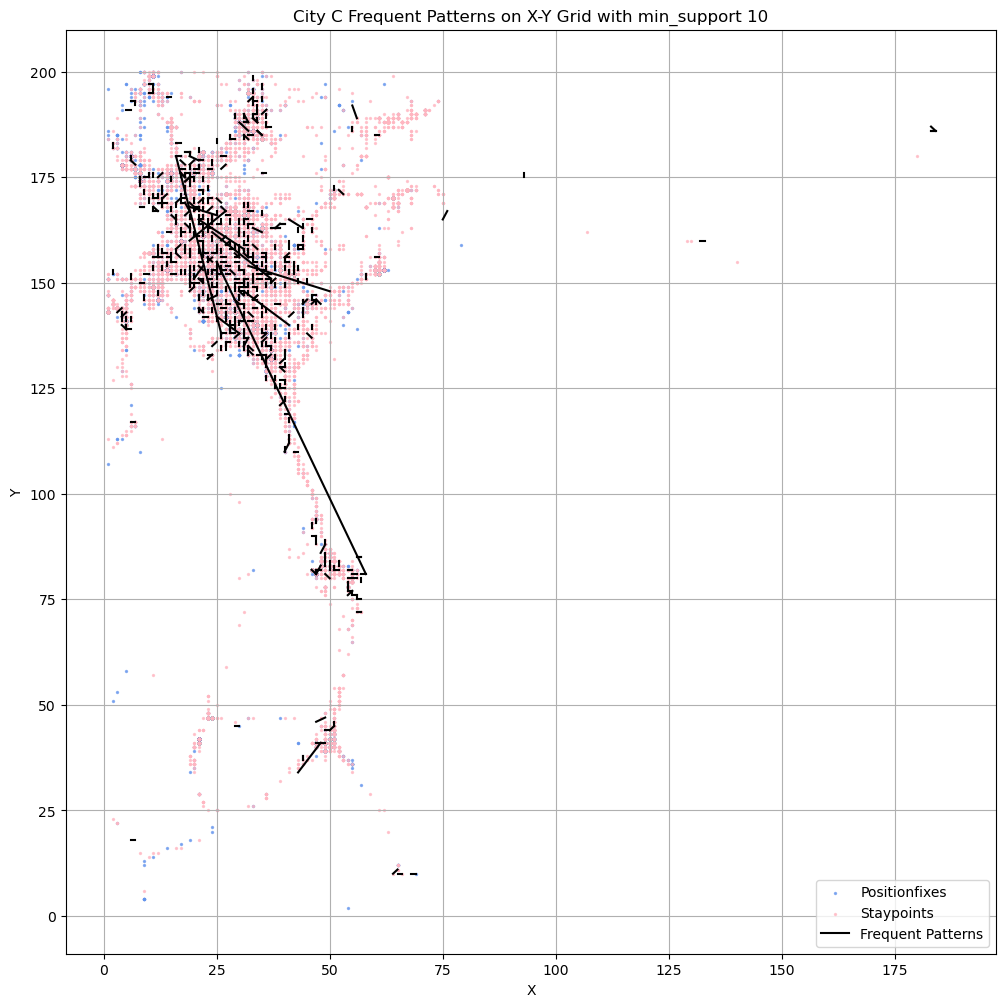

In [25]:
# Visualize top patterns
# Extract positionfixes and staypoints from a subset of processed data for visualization
positionfixes = pfs_chunk[pfs_chunk['staypoint_id'].isna()][:500000]
staypoints = pfs_chunk.dropna(subset=['staypoint_id'])[:500000]

plt.figure(figsize=(12, 12))
plt.scatter(positionfixes['x'], positionfixes['y'], label='Positionfixes', color='#6495ED', s=2, alpha=0.7)
plt.scatter(staypoints['x'], staypoints['y'], label='Staypoints', color='#FFB6C1', s=2, alpha=0.7)

# Plot each frequent pattern
for pattern, count in all_frequent_patterns.items():
    x_coords = [point[0] for point in pattern]
    y_coords = [point[1] for point in pattern]
    plt.plot(x_coords, y_coords, linestyle='-', alpha=1, linewidth=1.5, color='black')

# Add a legend entry for triplegs
plt.plot([], [], linestyle='-', color='black', label='Frequent Patterns')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'City C Frequent Patterns on X-Y Grid with min_support {min_support}')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Convert the frequent patterns to a DataFrame for easier saving
patterns_df = pd.DataFrame({
    'Pattern': [pattern for pattern in all_frequent_patterns.keys()],
    'Count': [count for count in all_frequent_patterns.values()]
})

In [27]:
patterns_df.head()

,Pattern,Count
0,"((10.0, 180.0),)",10
1,"((47.0, 89.0),)",10
2,"((22.0, 172.0),)",10
3,"((72.0, 2.0),)",10
4,"((38.0, 135.0),)",10


In [28]:
# Save the patterns to a CSV file
patterns_df.to_csv("CityC_frequent_patterns_minsup10.csv", index=False)

In [29]:
# Check for long patterns
long_patterns = patterns_df[patterns_df['Pattern'].apply(len) >= 5]

# Display the result
long_patterns

,Pattern,Count
